#Genetic Programming

In the lecture, we talked about genetic programming. Today we will try it out by practicing it on the problem of symbolic regression (i.e., finding a formula that fits the given data) and classification, i.e., finding a decision tree using genetic programming. We will use the `deap` library, which we briefly demonstrated last time.

We will start by importing and generating the data we will use for the regression.

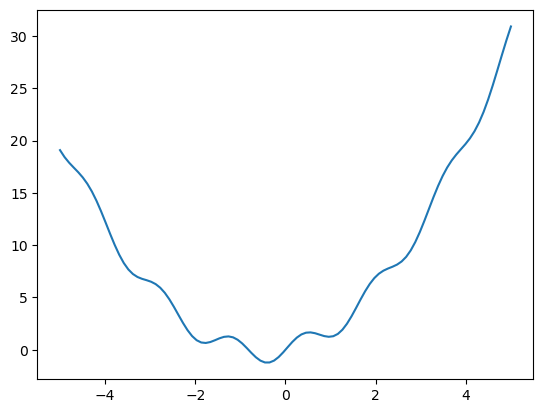

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x_train = np.linspace(-5, 5, 100)
y_train = x_train*x_train + x_train + np.sin(4*x_train)

plt.plot(x_train, y_train)
plt.show()

Let's prepare a helper function to display the created tree. This uses the pydot library (and the GraphViz program) to draw graphs. If you install pydot using `conda`, it graphviz should be installed automatically.

In [5]:
import pydot
from IPython.display import Image

#zobrazeni jedince jako stromu
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type='graph')
    for node in nodesDot:
        g.add_node(node)
    for f,t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

When working with genetic programming, we need to create a set of primitives - terminals and non-terminals that evolution will work with. There is a class `gp.PrimitiveSet` in `deap` for this, or `gp.PrimitiveSetTyped` for typed GPs. We'll show the typed case here because it's more general. But we'll only use one type, so there's actually no need.

In [6]:
import operator

from deap import gp

pset = gp.PrimitiveSetTyped('MAIN', [float], float) # the name of the set is MAIN, there is one float input and one float output
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(0.0, float)
pset.addPrimitive(np.sin, [float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)

In [7]:
from deap import creator, base, tools, algorithms

#definujeme fitness - pocita MSE a velikost jedince, vahy jsou nastavene nize (-1.0 a -0.01)
def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # vytvorime funkci, ktera pocita jedince
    vals = list(map(func, x))
    return np.sqrt(np.dot(vals-y, vals-y)), len(ind)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

#nastavime algoritmus
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

#limity na hloubku stromu
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [11]:
pop = toolbox.population(n=1000)
#ulozeni nejlepsiho jedince
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	                          fitness                          	                      size                     
   	      	-----------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max        	min    	nevals	std        	avg   	gen	max	min	nevals	std    
0  	1000  	46661.6	0  	4.53998e+07	11.4954	1000  	1.43499e+06	69.954	0  	916	4  	1000  	123.119
1  	572   	117.134	1  	2747.62    	19.712 	572   	109.875    	47.025	1  	650	2  	572   	84.3348
2  	541   	102.763	2  	306.269    	19.712 	541   	23.6471    	33.196	2  	486	2  	541   	52.6618
3  	551   	93.9016	3  	1087.13    	7.03293	551   	59.8477    	29.858	3  	484	2  	551   	36.67  
4  	560   	80.9775	4  	2189.8     	7.03293	560   	86.5768    	27.441	4  	281	2  	560   	20.254 
5  	511   	74.452 	5  	7120.07    	7.03293	511   	245.599    	26.797	5  	113	3  	511   	13.8898
6  	548   	53.7458	6  	2062.03    	7.03293	548   	87.349     	26.072	6  	113	3  	548   	11

Let us show the best individual at the end of evolution.

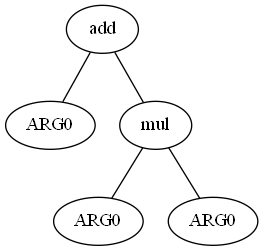

In [12]:
Image(plot_tree(hof[0]))

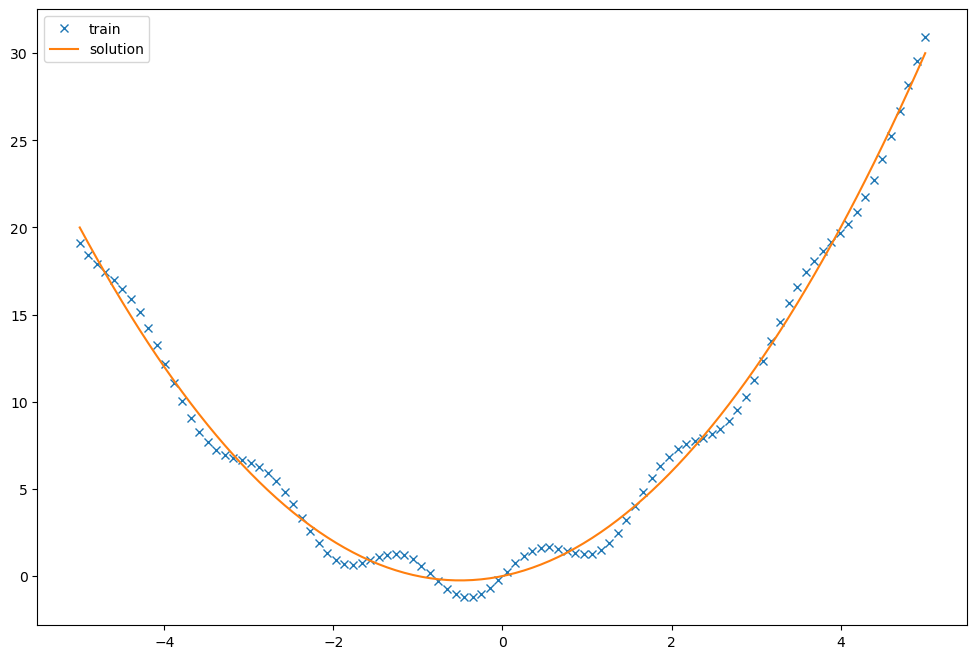

In [13]:
# compare the function we found with the training data
sol = gp.compile(hof[0], pset)

y = list(map(sol, x_train))
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, 'x', label='train')
plt.plot(x_train, y, label='solution')
plt.legend()
plt.show()

## Exercise

Try using genetic programming to solve the classification problem, e.g. for a dataset with irises. Think about how to define a set of primitives and fitness. Implement and run the algorithm.